## Simulate the dataset

We simulate 40 workers in a hammer-spammer setting. There are $100\times 0.7=70$ spammers that will answer randomly. All other workers answer the true labels.

In [1]:
from pathlib import Path
path = (Path() / ".." / "_build" / "notebooks")
path.mkdir(exist_ok=True, parents=True)

! peerannot simulate --n-worker=100 --n-task=300  --n-classes=5 \
                     --strategy hammer-spammer \
                     --ratio 0.7 \
                     --feedback=10 --seed 0 \
                     --folder {path}


    Saved answers at ../_build/notebooks/answers.json 

    Saved ground truth at ../_build/notebooks/ground_truth.npy
    


Note that if the dataset comes with an install file (like the `LabelMe` dataset available in peerannot), simply run the install file to download the dataset:

```
$ peerannot install labelme.py
```

Below, we always precise where the labels are stored in the dataset. This is to hilight that multiple datasets can be used with the same code, as long as the labels are stored in the same way.

## Value of the krippendorff alpha

The closer to 0, the less reliable the data. The closer to 1, the more reliable the data.


In [2]:
! peerannot identify -s krippendorffalpha {path} \
                     --labels {path}/answers.json \
                     --n-classes 5


Running the following configuration:
----------
- Data at ../_build/notebooks
- number of classes: 5
- labels: ../_build/notebooks/answers.json
- hard_labels: None
- use_pleiss: False
- model: resnet18
- n_epochs: 50
- alpha: 0.01
- topk: 0
- n_params: 3072
- lr: 0.1
- pretrained: False
- momentum: 0.9
- metadata_path: None
- decay: 0.0005
- img_size: 224
- maxiter_ds: 50
- optimizer: SGD
- data_augmentation: False
- freeze: False
- matrix_file: None
- seed: 0
----------


alpha saved at /home/circleci/project/doc/_build/notebooks/identification/krippendorff_alpha.npy 
 alpha=np.float64(0.08172184891604384)


We obtain $\alpha\simeq 0.08$ which indicates that the data is not reliable.

## Identify spammers

If there are ambiguities, we can identify spammers by looking at the spammer score. The closer to 0, the more likely the annotator is a spammer.

In [3]:
! peerannot identify -s spam_score {path} \
                     --labels {path}/answers.json \
                     --n-classes 5

Running the following configuration:
----------
- Data at ../_build/notebooks
- number of classes: 5
- labels: ../_build/notebooks/answers.json
- hard_labels: None
- use_pleiss: False
- model: resnet18
- n_epochs: 50
- alpha: 0.01
- topk: 0
- n_params: 3072
- lr: 0.1
- pretrained: False
- momentum: 0.9
- metadata_path: None
- decay: 0.0005
- img_size: 224
- maxiter_ds: 50
- optimizer: SGD
- data_augmentation: False
- freeze: False
- matrix_file: None
- seed: 0
----------
Running DS model


Dawid and Skene:   0%|                                   | 0/50 [00:00<?, ?it/s]

Dawid and Skene:  14%|███▊                       | 7/50 [00:00<00:00, 62.16it/s]

Finished:  22%|███████▎                         | 11/50 [00:00<00:00, 55.62it/s]
Spam scores saved at /home/circleci/project/doc/_build/notebooks/identification/spam_score.npy


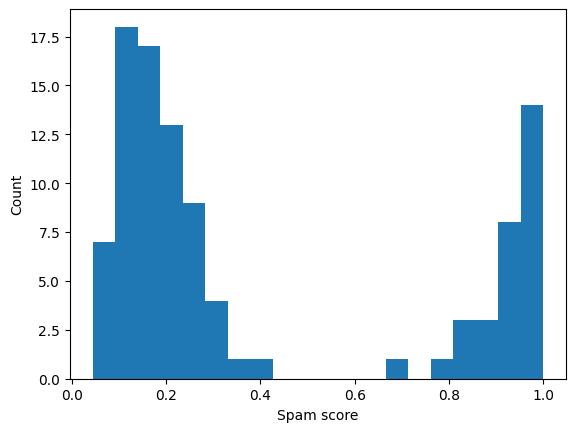

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spam_scores = np.load(path / "identification" / "spam_score.npy")
plt.figure()
plt.hist(spam_scores, bins=20)
plt.xlabel("Spam score")
plt.ylabel("Count")
plt.show()

We can get the ID of workers with a spam score below $0.5$:

In [5]:
print(np.where(spam_scores < 0.5))

(array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
       98, 99]),)


## Aggregation with and without identification

In [6]:
from peerannot.models import Dawid_Skene as DS
from peerannot.models import MV
import json

with open(path / "answers.json") as f:
    answers = json.load(f)

gt = np.load(path / "ground_truth.npy")

/home/circleci/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
y_mv = MV(answers, n_classes=5).get_answers()
ds = DS(answers, n_classes=5, n_workers=100)
ds.run()
y_ds = ds.get_answers()
print(f"""
        - MV accuracy: {np.mean(y_mv == gt)}
        - DS accuracy: {np.mean(y_ds == gt)}
      """)

Dawid and Skene:   0% 0/50 [00:00<?, ?it/s]

Dawid and Skene:  14% 7/50 [00:00<00:00, 60.73it/s]

Finished:  22% 11/50 [00:00<00:00, 60.73it/s]      

Finished:  22% 11/50 [00:00<00:00, 51.23it/s]


        - MV accuracy: 0.8166666666666667
        - DS accuracy: 0.91
      


Because the DS model models the confusions, it was able to generate better predicions than the majority vote. Let's see if we can identify the spammers and improve the predictions.

In [8]:
id_spammers = list(np.where(spam_scores < 0.5)[0])

ans_cleaned = {}
worker_ids = {}
for task in answers.keys():
    ans_cleaned[task] = {}
    for worker, label in answers[task].items():
        if int(worker) in id_spammers:
            pass
        else:
            if worker_ids.get(worker, None) is None:
                worker_ids[worker] = len(worker_ids)
            ans_cleaned[task][worker_ids[worker]] = label

In [9]:
y_mv = MV(ans_cleaned, n_classes=5).get_answers()
ds = DS(ans_cleaned, n_classes=5, n_workers=len(worker_ids))
ds.run()
y_ds = ds.get_answers()
print(
    f"""
        - MV accuracy: {np.mean(y_mv == gt)}
        - DS accuracy: {np.mean(y_ds == gt)}
      """
)

/home/circleci/project/peerannot/models/aggregation/DS.py:83: RuntimeWarning: invalid value encountered in divide
  self.T = np.where(tdim > 0, T / tdim, 0)


Dawid and Skene:   0% 0/50 [00:00<?, ?it/s]

Finished:   6% 3/50 [00:00<00:00, 48.42it/s]

Finished:   6% 3/50 [00:00<00:00, 47.36it/s]


        - MV accuracy: 0.9933333333333333
        - DS accuracy: 0.9933333333333333
      


Now that we cleaned the data, we can aggregate the labels again and obtain a majority vote that performs as good as the DS strategy !

Similar modifications can be done by identifying the ambiguous tasks and not the workers.